# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = "lab 2 data/train.p"
testing_file = "lab 2 data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
print("Loaded dataset")

Loaded dataset


In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]
print("X_train shape = ", X_train.shape)

# TODO: number of testing examples
n_test = X_test.shape[0]
print("X_test shape = ", X_train.shape)

# TODO: what's the shape of an image?
image_shape = train['sizes']
print(image_shape)

# TODO: how many classes are in the dataset
print("Number of train labels = ", max(train['labels']))
print("Number of test labels = ", max(test['labels']))      
n_classes = max(train['labels']) + 1  # zero-based labels mean we have to add 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


X_train shape =  (39209, 32, 32, 3)
X_test shape =  (39209, 32, 32, 3)
[[30 29]
 [30 30]
 [30 30]
 ..., 
 [62 58]
 [69 63]
 [69 68]]
Number of train labels =  42
Number of test labels =  42
Number of training examples = 39209
Number of testing examples = 12630
Image data shape = [[30 29]
 [30 30]
 [30 30]
 ..., 
 [62 58]
 [69 63]
 [69 68]]
Number of classes = 43


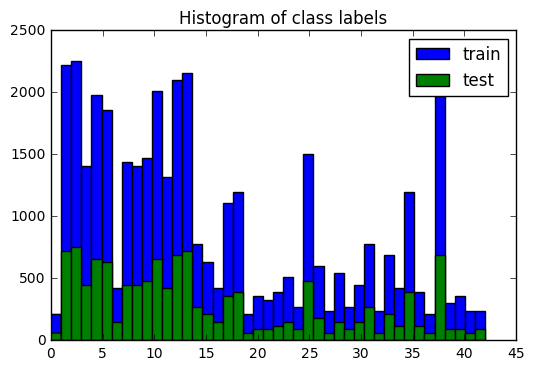

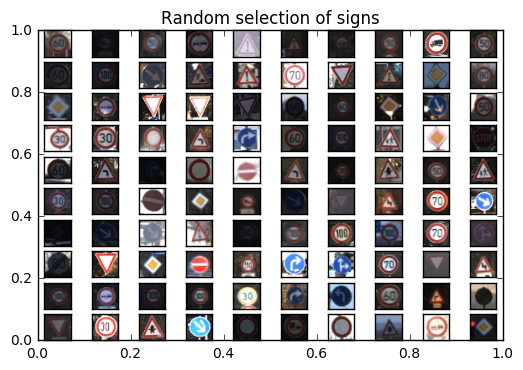

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

import matplotlib.pyplot as plt
import numpy as np
import random


def plot_histogram():
    # from https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html
    fig = plt.figure()
    plt.hist(y_train, bins=n_classes, label='train')
    plt.hist(y_test, bins=n_classes, label='test')
    plt.legend()
    plt.title("Histogram of class labels")
    plt.show()

def plot_images(images, grey=False):
    # from https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/fig/mnist.py
    fig = plt.figure()
    plt.title("Random selection of signs")
    for x in range(10):
        for y in range(10):
            i = 10*y+x
            ax = fig.add_subplot(10, 10, i + 1)
            if grey:
                imgplot = plt.imshow(images[i].reshape(32, 32), cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)
            else:
                imgplot = plt.imshow(images[i])
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()

plot_histogram()

signs = random.sample(list(X_train), 100)
plot_images(signs)


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

X_train_grey shape (39209, 32, 32, 1)
One hot encoder has  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]  classes


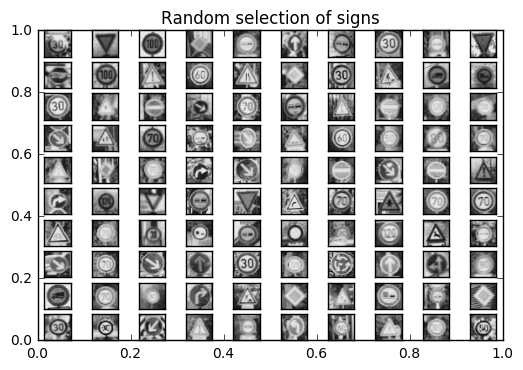

Data preprocessing complete


In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

def normalize_minmax(X):
    # Min-Max scaling for image data
    a = 0.1
    b = 0.9
    image_max = 255
    image_min = 0
    return a + (X - image_min) * (b - a) / (image_max - image_min)

def image_histogram_equalization(image, number_bins=256):
    # from http://stackoverflow.com/questions/28518684/histogram-equalization-of-grayscale-images-with-numpy
    # from http://www.janeriksolem.net/2009/06/histogram-equalization-with-python-and.html

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, normed=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape)

def RGB2GREY(X):
    # https://en.wikipedia.org/wiki/YUV
    #conversion = np.array([[0.299, 0.587, 0.114], 
    #                       [-0.14713, -0.28886, 0.436],
    #                       [0.615, -0.51499, -0.10001]])

    new_X = []
    for image in X:
        grey = np.dot(image[...,:3], [[0.299], [0.587], [0.114]])
        grey = grey - np.mean(grey) + 128 # global illumination normalisation by subtracting the mean and centering on 128 
        equalized = image_histogram_equalization(grey)
        new_X.append(normalize_minmax(equalized))
    return np.array(new_X)


def onehot_encode(y_train, y_test):
    # One-hot-encode the labels
    from sklearn import preprocessing
    encoder = preprocessing.LabelBinarizer()
    encoder.fit(y_train)
    print("One hot encoder has ", encoder.classes_, " classes")
    y_train_onehot = encoder.transform(y_train)
    y_test_onehot = encoder.transform(y_test)
    
    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    y_train_onehot = y_train_onehot.astype(np.float32)
    y_test_onehot = y_test_onehot.astype(np.float32)

    return y_train_onehot, y_test_onehot

X_train_grey = RGB2GREY(X_train)
print("X_train_grey shape", X_train_grey.shape)
X_test_grey = RGB2GREY(X_test)

y_train_onehot, y_test_onehot = onehot_encode(y_train, y_test)

signs = random.sample(list(X_train_grey * 256.), 100)
plot_images(signs, grey=True)

print("Data preprocessing complete")

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

After reading through the Sermanet paper it was clear that grey/YUV is the way to go.  Indeed from the paper, grey (i.e. the luminance component) was used for the best results.  From this I decided to convert each RGB pixel to YUV using the formula from http://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python.  After converting each pixel to grey I removed the mean of that image (global normalisation) and added back 128 to centre it between 0 and 255.  Then I normalized the image histogram and finally did min-max scaling on the resulting value to yield a value between 0.1 and 0.9.  This should help backprop to navigate down the gradient without jumping over the optimum (as in the case of poorly distributed features).

The labels need to be one-hot encoded in order to do classification with neural networks (where the number of classes is over 2).  

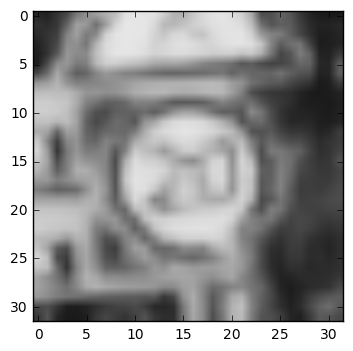

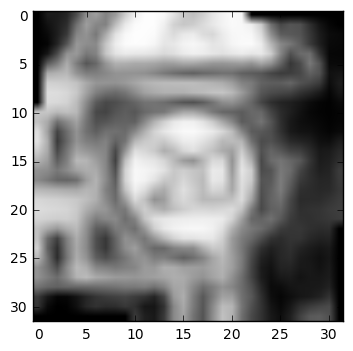

In [5]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

import scipy

img = X_train_grey[0].reshape(32, 32) * 256.
plt.imshow(img, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)
plt.show()
rot = scipy.misc.imrotate(img, -5, interp='bilinear')
plt.imshow(rot, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)
plt.show()



### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

I dabbled with the idea of generating additional data, but decided not to in the end.  I felt that I could go back to this task if I had enough time, but considering that from the Sermanet paper they only gained an improvement of 0.22% by increasing the dataset 5 times, my firest instinct was that it would likely be a marginal improvement.

After running the training/testing step many times it seems to me that the big problem with this dataset is that some classes are not well represented.  This imbalance in the dataset results in a real struggle to correctly classify the signs that are poorly represented in the dataset.  You can see this later on in the confusion matrix visualisation - most of the errors are in the classes that have few samples.

I've spent a long time on this lab already, so I'm not going to attempt to address it, but if I had some more time I would create a weight vector that is the inverse of the histogram (i.e. weight classes that are poorly represented more) and then use the resampling wheel from the Udacity robotics particle filter class to randomly resample the data.  For each sample I would apply a small random rotation (I started trying it out above), and small random scaling and a small random translation.  This *should* result in a more balanced dataset and I expect that doing so would help push up the classification results on test data. 



In [6]:
import tensorflow as tf

def create_2_layer_model(color_channels=3):
    
    image_width = 32
    image_height = 32
    n_input = image_width * image_height
    
    n_hidden_1 = 256
    n_hidden_2 = 64
    
    # tf Graph input
    features = tf.placeholder("float", [None, image_width, image_height, color_channels])
    labels = tf.placeholder("float", [None, n_classes])
    keep_prob = tf.placeholder(tf.float32)    
  

    # Set the weights and biases
    weights = {
        'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], mean=0.0, stddev=0.35)),
        'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], mean=0.0, stddev=0.35)),
        'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes], mean=0.0, stddev=0.35))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'b2': tf.Variable(tf.random_normal([n_hidden_2])),
        'out': tf.Variable(tf.random_normal([n_classes]))
    }
    
    features_flat = tf.reshape(features, [-1, n_input])

    hidden1 = tf.nn.relu(tf.add(tf.matmul(features_flat, weights['h1']), biases['b1']))

    hidden2 = tf.nn.relu(tf.add(tf.matmul(hidden1, weights['h2']), biases['b2']))

    logits = tf.matmul(hidden2, weights['out']) + biases['out']

    prediction = tf.nn.softmax(logits)    

    top_k = tf.nn.top_k(prediction, k=5)    
    
    prediction_class = tf.argmax(prediction, dimension=1)    

    # Training loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))
    
    # Determine if the predictions are correct
    is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
    # Calculate the accuracy of the predictions
    accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))
    
    print("2 layer model created")
    
    return features, labels, keep_prob, loss, prediction_class, top_k, accuracy

In [7]:
import tensorflow as tf

def create_convolutional_model(color_channels=3):
    
    image_width = 32
    image_height = 32
    
    kernel_size = 5
    k_output1 = 32
    k_output2 = 64
    
    n_hidden_1 = 1024
#    n_hidden_2 = 256
       
    # tf Graph input
    features = tf.placeholder("float", [None, image_width, image_height, color_channels])
    labels = tf.placeholder("float", [None, n_classes])
    keep_prob = tf.placeholder(tf.float32)

    # Set the weights and biases
    weights = {
        # kernel_size x kernel_size conv, color_channels input, k_output1 outputs
        'c1':tf.Variable(tf.truncated_normal([kernel_size, kernel_size, color_channels, k_output1], stddev=0.1)),
        'c2':tf.Variable(tf.truncated_normal([kernel_size, kernel_size, k_output1, k_output2], stddev=0.1)),
        'f1': tf.Variable(tf.truncated_normal([image_width//4 * image_width//4 * k_output2, n_hidden_1], stddev=0.1)),
#        'h1': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], stddev=0.1)),
        'out': tf.Variable(tf.truncated_normal([n_hidden_1, n_classes], stddev=0.1))
    }
    biases = {
        'c1': tf.Variable(tf.truncated_normal([k_output1], stddev=0.1)),
        'c2': tf.Variable(tf.truncated_normal([k_output2], stddev=0.1)),
        'f1': tf.Variable(tf.truncated_normal([n_hidden_1], stddev=0.1)),
#        'h1': tf.Variable(tf.truncated_normal([n_hidden_2], stddev=0.1)),
        'out': tf.Variable(tf.truncated_normal([n_classes], stddev=0.1))
    }
    
    def conv_layer(x, W, b, stride):
        c1 = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')
        c2 = tf.nn.bias_add(c1, b)
        return tf.nn.relu(c2)
    
    conv1 = conv_layer(features, weights['c1'], biases['c1'], stride=1)
    
    maxpool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    conv2 = conv_layer(maxpool1, weights['c2'], biases['c2'], stride=1)
    
    maxpool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    reshaped = tf.reshape(maxpool2, [-1, weights['f1'].get_shape().as_list()[0]])
 
    # Fully connected layer
    fc1 = tf.nn.relu(tf.add(tf.matmul(reshaped, weights['f1']), biases['f1']))
    
#    hidden = tf.nn.relu(tf.add(tf.matmul(fc1, weights['h1']), biases['h1']))

    # Apply dropout
    dropped = tf.nn.dropout(fc1, keep_prob)      
    
    logits = tf.add(tf.matmul(dropped, weights['out']), biases['out'])

    prediction = tf.nn.softmax(logits)
    
    top_k = tf.nn.top_k(prediction, k=5)

    prediction_class = tf.argmax(prediction, dimension=1)    

    # Training loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))
    
    # L2 regularization for the fully connected parameters.
    regularizers = (tf.nn.l2_loss(weights['f1']) + tf.nn.l2_loss(biases['f1']) +
#                    tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(biases['h1']) +
                    tf.nn.l2_loss(weights['out']) + tf.nn.l2_loss(biases['out']))
      # Add the regularization term to the loss.
    loss += 5e-4 * regularizers
    
    # Determine if the predictions are correct
    is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
    # Calculate the accuracy of the predictions
    accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))
    
    print("convolutional model created")
    
    return features, labels, keep_prob, loss, prediction_class, top_k, accuracy

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My first model was a 2 layer fully connected perceptron. I had built a similar model on MNIST and I thought this would be a good starting point to check my parameters like learning rate, batch size etc.

After testing end-to-end on a 2 layer model I started on a convolutional model.  Reading the Sermanet paper it seems that 2 convolutional layers with max-pooling, followed by a fully connected layer and an output layer yielded good results.  This seemed a good place to start.

I chose a 5x5 kernel for the conv2d operation - this 'feels' like a good size compared to the image 32x32.  I chose a depth of 32 for the first conv layer and a depth of 64 for the second layer.  The maxpool operation between halved the width and height at each stage so that the output of the second maxpool was (32/4) 8x8.  From there I flattened the cube and fully connected it to a hidden layer of 1024 to try to capture high level features.  I included a dropout node here to prevent overfitting.

The final step is predicting the classes in an output layer to yield logits.  As before I used softmax and cross entropy to form a loss function, but I also included a L2 regularisation term to penalise large weights for the 2 final layers.

The relevant nodes are returned so that they can be used in the training and evaluation steps.

In [8]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [9]:
#features, labels, keep_prob, loss, prediction_class, top_k, accuracy = create_2_layer_model(color_channels=1)
features, labels, keep_prob, loss, prediction_class, top_k, accuracy = create_convolutional_model(color_channels=1)


convolutional model created


.....
Validation accuracy is 0.9132876396179199
.....
Validation accuracy is 0.967355489730835
.....
Validation accuracy is 0.9834228754043579
.....
Validation accuracy is 0.9928591251373291
.....
Validation accuracy is 0.9966847896575928
.....
Validation accuracy is 0.9971948862075806
.....
Validation accuracy is 0.9977049827575684
.....
Validation accuracy is 0.9974498748779297
.....
Validation accuracy is 0.9984700679779053
.....
Validation accuracy is 0.9987249970436096


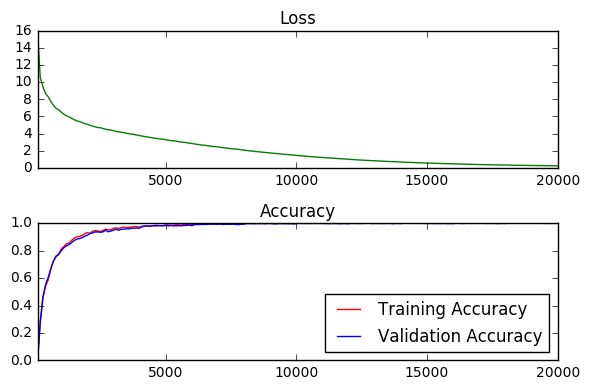

Cross fold validation accuracy is 0.9843155145645142
Model saved in file: ./model.ckpt


In [10]:

import math
from sklearn.model_selection import StratifiedShuffleSplit

epochs = 5
batch_size = 100
learning_rate = 0.0001
num_folds = 10
dropout = 0.5 # probability to keep units

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)    

# The accuracy measured against the validation set
validation_accuracies = []

# Measurements use for graphing loss and accuracy
log_batch_step = 100
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

# Create an operation that initializes all variables
init = tf.initialize_all_variables()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

with tf.Session() as session:
    session.run(init)
    
    skf = StratifiedShuffleSplit(n_splits=num_folds, random_state=0)
   
    # The training data is a tensor of (sample, length, width, channels):
    # scikit-learn KFolds expect a tuple of (samples, features), so use np.zeros instead
    # because only y is used to determine the split
    for train_index, validation_index in skf.split(np.zeros(n_train), y_train):
        train_features, valid_features = X_train_grey[train_index], X_train_grey[validation_index]
        train_labels, valid_labels = y_train_onehot[train_index], y_train_onehot[validation_index]
        
        batch_count = int(math.ceil(len(train_features) / batch_size))
    
        for epoch_i in range(epochs):
            print(".", end="")
        
            # The training cycle
            for batch_i in range(batch_count):
                # Get a batch of training features and labels
                batch_start = batch_i*batch_size
                batch_features = train_features[batch_start:batch_start + batch_size]
                batch_labels = train_labels[batch_start:batch_start + batch_size]

                # Run optimizer
                session.run( [optimizer, loss], feed_dict={features: batch_features,
                                                           labels: batch_labels, 
                                                           keep_prob: dropout})

                # Log every 100 batches
                if not batch_i % log_batch_step:
                    # Calculate Training and Validation accuracy
                    training_accuracy = session.run(accuracy, feed_dict={features: train_features[:4096],
                                                                         labels: train_labels[:4096], 
                                                                         keep_prob: 1.0})
                    validation_accuracy, l = session.run([accuracy, loss], feed_dict={features: valid_features,
                                                                                      labels: valid_labels,
                                                                                      keep_prob: 1.0})

                    # Log batches
                    previous_batch = batches[-1] if batches else 0
                    batches.append(log_batch_step + previous_batch)
                    loss_batch.append(l)
                    train_acc_batch.append(training_accuracy)
                    valid_acc_batch.append(validation_accuracy)

        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict={features: valid_features,
                                                               labels: valid_labels,
                                                               keep_prob: 1.0})
        print('')
        print('Validation accuracy is {}'.format(validation_accuracy))
        validation_accuracies.append(validation_accuracy)

    loss_plot = plt.subplot(211)
    loss_plot.set_title('Loss')
    loss_plot.plot(batches, loss_batch, 'g')
    loss_plot.set_xlim([batches[0], batches[-1]])
    acc_plot = plt.subplot(212)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
    acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
    acc_plot.set_ylim([0, 1.0])
    acc_plot.set_xlim([batches[0], batches[-1]])
    acc_plot.legend(loc=4)
    plt.tight_layout()
    plt.show()

    print('Cross fold validation accuracy is {}'.format(np.mean(validation_accuracies)))
    
    # save the tensorflow model
    save_path = saver.save(session, "./model.ckpt")
    print("Model saved in file: %s" % save_path)

Model restored.
Test accuracy is 0.9285041093826294


/home/brian/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log


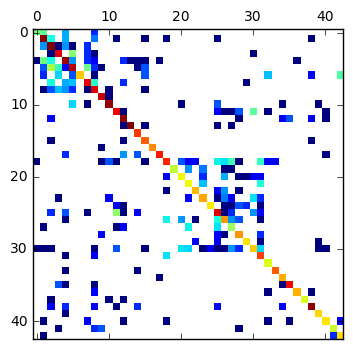

In [16]:
from sklearn.metrics import confusion_matrix

# Create an operation that initializes all variables
init = tf.initialize_all_variables()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

with tf.Session() as session:
    session.run(init)
    
    # Restore variables from disk.
    saver.restore(session, "./model.ckpt")
    print("Model restored.")
    
    test_features = X_test_grey
    test_labels = y_test_onehot
    
    test_predictions, test_accuracy = session.run([prediction_class , accuracy],
                                                 feed_dict={features: test_features,
                                                            labels: test_labels, 
                                                            keep_prob: 1.0})
    print('Test accuracy is {}'.format(test_accuracy))
    
    # Get the confusion matrix using sklearn.  
    confusion = confusion_matrix(y_true=y_test, y_pred=test_predictions)
    
    plt.matshow(np.log(confusion), fignum=100, cmap=plt.cm.jet) # use the log to help with visualisation

    plt.show()

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

From the class label histograms it was clear that the biggest challenge would be to perform well on classes that are not well represented in the dataset.  I had already decided to do K-Fold cross validation, holding out 100/K percent of the data on each fold to do validation.  Scikit-learn has a nice addition to this called StratifiedKFold.  The idea here is that the proportions of labels in the training set are the same as in the validation set.  Furthermore, StratifiedShuffleSplit will provide randomised (shuffled) data that is also stratified.  With this I was satisfied that the validation scores for each fold will be representative of the test set.

For training I initially used the SGD as we used in previous assignments, with a relatively small learning rate. However, I found that the model converged to a solution much faster when I used the ADAM optimiser. Batches are size 100 which seems to return good results.  I use a dropout of 0.5 to make the network more robust.



### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

My overall approach was very much trial-and-error, on the assumption that the hyperparameters are independent (e.g. batch size is not correlated with number of nodes in the fully-connected layer).  If this assumption is wrong, then the search space becomes prohibitively large and I don't really have a hope of finding the global optimum.

My first attempt was a 2 layer multilayer perceptron with 256 and 64 nodes in the respective layers.  I had used this model successfully to classify the MNIST dataset so I felt it would be a good starting point.  You can see this from the code in the function "def create_2_layer_model(color_channels=3)".

Initial results from the MNIST model settings were poor at around 5%, so it seems that the network wasn't learning anything. My thinking at this point was that the strategy of classifying using only pixel data (as with MNIST) was not going to yield good results.

The next step was to introduce convolutions and max-pooling into this model. The idea is that the model learns features and in most of the literature I've read, 2 convolution/max-pooling steps seem standard.  Since this is my first attempt at deep learning I thought it reasonable to use this architecture as a starting point.

Initial results with a batch size of 100 and 10 epochs and the SGD optimiser were poor with a learning rate of 0.01 so my first knob to tune was the learning rate.  I tried variations from [1, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001, 0.000003 and 0.000001].  From this I found that 0.0001 yielded the best results, but the accuracy on the validation set was only at around 10%.  I tried 100 epochs and found the cross-fold validation accuracy increased to 0.986.  At that point the classifier was learning, but the test accuracy was only around 85%.  I tried pushing to 1000 epochs (took nearly a day to learn) and didn't really improve the test accuracy even though the validation accuracy saturated at 100%.  I varied the batch size from [10, 50, 100, 100] and settled on 100 with best results.  I varied the number of nodes in the fully connected layer from [32, 64, 128, 256, 512 and 1024] and the output layer with [64, 128, 256].  My graphics card couldn't handle the bigger combinations - Tensorflow was throwing out of memory errors. The biggest gain came when I changed the optimiser to the ADAM optimiser - suddenly the accuracy curve became much steeper and then the 100 epochs I was using were likely overtraining the network because it was showing near 100% accuracy on validation after 10 epochs.  I tried [2, 5, 10] epochs as well and found 5 to be a good compromise, not being saturated for too long.  I also tried variations of the number of folds [3, 5, 10, 20] and didn't find much change, so I stuck with 10 (which leaves of 10% of the data each time). 

At this point I was getting approx 92% accuracy, so I tried adding an extra layer to classifier, but that did nothing to improve the accuracy, so I stopped there.

So I was struggling to figure out what to do to get better results on the test set, when I already had 99% on the average cross-validation.  Typically the solution here is to avoid overfitting using a variety of techniques like early termination (terminate after 5 epochs, not 1000 as in my first attempt), use dropout (tried with [50, 66, 75] and settled on 50) and do cross-fold validation (already doing 10-fold). I added regularisation which improved accuracy on the test data by about 1% (92 -> 93), but that's still not up at the 98% reported by the Sermanet paper.

Looking at the confusion matrix it appears to struggle with classes that have few instances, so I think the reason why it's not doing well is because of the data imbalance.  As a next step if I had more time I'd generate more data, sampling according to the inverse of the proportion to try to rebalance the dataset.

There are also other knobs I could try to tune - the kernel size could be 3x3 or 7x7, I could try another convolution layer.  It's really difficult to check through every possible combination.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [12]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import csv

signnames = []
with open('signnames.csv', newline='') as csvfile:
    filereader = csv.reader(csvfile, delimiter=',')
    for row in filereader:
        print(', '.join(row))
        signnames.append(row[1])

# remove the header
del signnames[0]

print(signnames)


ClassId, SignName
0, Speed limit (20km/h)
1, Speed limit (30km/h)
2, Speed limit (50km/h)
3, Speed limit (60km/h)
4, Speed limit (70km/h)
5, Speed limit (80km/h)
6, End of speed limit (80km/h)
7, Speed limit (100km/h)
8, Speed limit (120km/h)
9, No passing
10, No passing for vechiles over 3.5 metric tons
11, Right-of-way at the next intersection
12, Priority road
13, Yield
14, Stop
15, No vechiles
16, Vechiles over 3.5 metric tons prohibited
17, No entry
18, General caution
19, Dangerous curve to the left
20, Dangerous curve to the right
21, Double curve
22, Bumpy road
23, Slippery road
24, Road narrows on the right
25, Road work
26, Traffic signals
27, Pedestrians
28, Children crossing
29, Bicycles crossing
30, Beware of ice/snow
31, Wild animals crossing
32, End of all speed and passing limits
33, Turn right ahead
34, Turn left ahead
35, Ahead only
36, Go straight or right
37, Go straight or left
38, Keep right
39, Keep left
40, Roundabout mandatory
41, End of no passing
42, End of n

example files  ['warning.jpeg', '30.jpeg', '7-5-ton.jpeg', 'no-entry.jpeg', 'T.jpeg', '5degrees.jpeg', 'no-left-turn.jpeg']


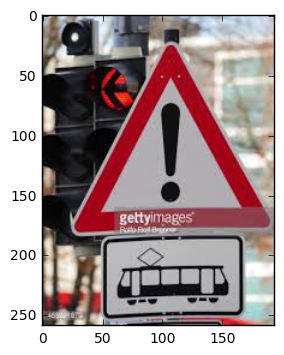

rgb shape  (32, 32, 3)


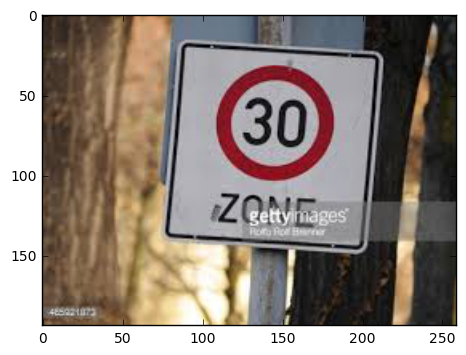

rgb shape  (32, 32, 3)


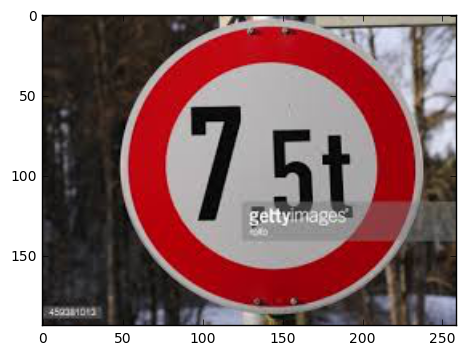

rgb shape  (32, 32, 3)


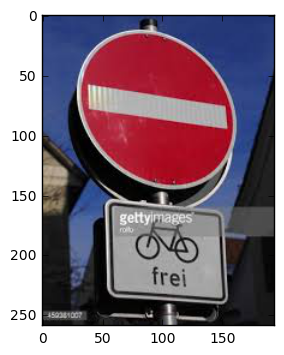

rgb shape  (32, 32, 3)


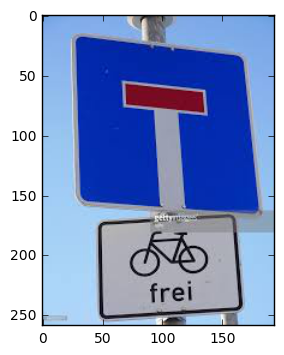

rgb shape  (32, 32, 3)


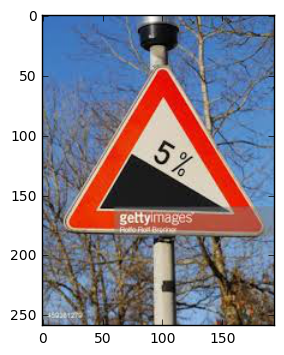

rgb shape  (32, 32, 3)


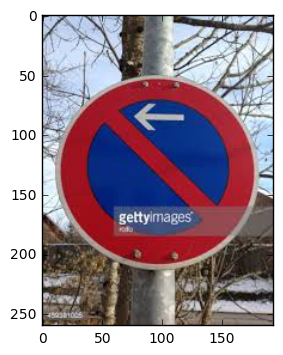

rgb shape  (32, 32, 3)


In [13]:
from os import walk
from PIL import Image

files = []
for (dirpath, dirnames, filenames) in walk("./examples/"):
    files.extend(filenames)
    break

print("example files ", files)

test_images = []
test_rgb = []
for f in files:
    image = Image.open("./examples/" + f)
    test_rgb.append(image)
    plt.imshow(image)
    plt.show()
    
    resized = image.resize((32, 32))
    rgb = np.asarray(resized)
    print("rgb shape ", rgb.shape)

    grey = RGB2GREY(rgb)
    test_images.append(grey)



### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

The big difference in the images I've chosed is that they're not cropped as well as the dataset images are. Also, some of them have a small sign below that's not in any training data. Images are plotted.

Model restored.
Predicted  Children crossing , expected  General caution


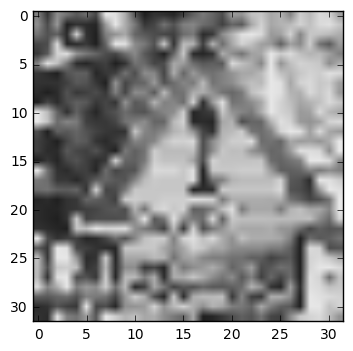

Predicted  General caution , expected  30km/h


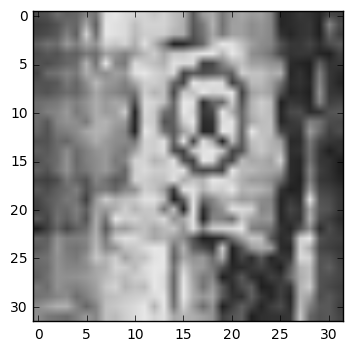

Predicted  Speed limit (20km/h) , expected  7.5ton


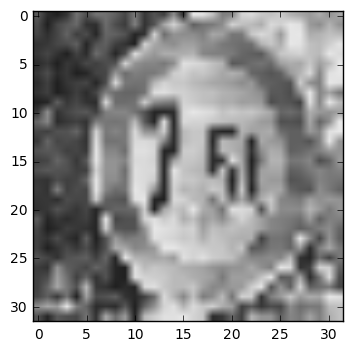

Predicted  Priority road , expected  no entry


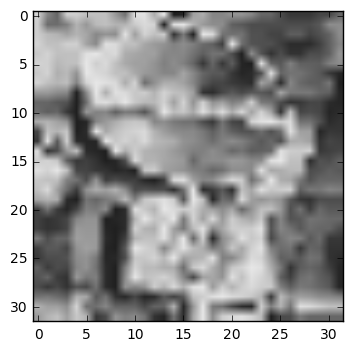

Predicted  Road work , expected  T junction


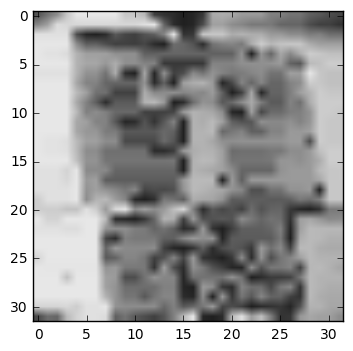

Predicted  Slippery road , expected  5 degree slope


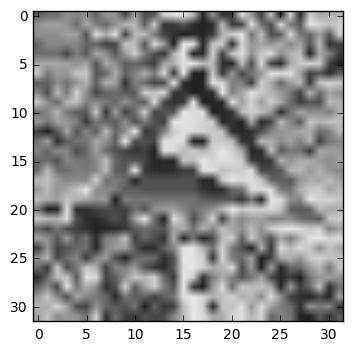

Predicted  Keep right , expected  no left turn


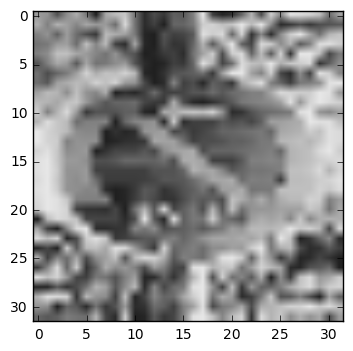

In [14]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

# Create an operation that initializes all variables
init = tf.initialize_all_variables()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

with tf.Session() as session:
    session.run(init)
    
    # Restore variables from disk.
    saver.restore(session, "./model.ckpt")
    print("Model restored.")
       
    test_predictions = session.run(prediction_class, feed_dict={features: test_images, 
                                                                labels: test_labels, # dummy 
                                                                keep_prob: 1.0})
    
    expected_labels = ['General caution', '30km/h', '7.5ton', 'no entry', 'T junction', '5 degree slope', 'no left turn']
    
    
    for image, prediction, expected in zip(test_images, test_predictions, expected_labels):
        print("Predicted ", signnames[prediction], ", expected ", expected)
        plt.imshow(image.reshape(32,32) * 256., cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)
        plt.show()


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

Not at all.  These are images picked from a Google search of German traffic signs, and even so it's not doing well. 

The first is a warning sign, but the classifier thinks it's Children crossing

The second is a 30km/h, but the classifier thinks it's Traffic signals

The third a 7.5ton sign, but the classifier thinks it's Speed limit (20km/h)

The fourth is a no entry, but the classifier thinks it's Priority road

The fifth is a T junction, but the classifier thinks it's Road work

The sixth is a  5 degree slope, but the classifier thinks it's Slippery road

The 7th is a  no left turn, but the classifier thinks it's Keep right (but this is probably correct)

Model restored.


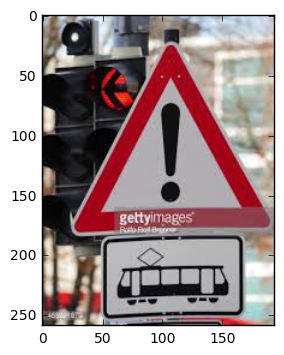

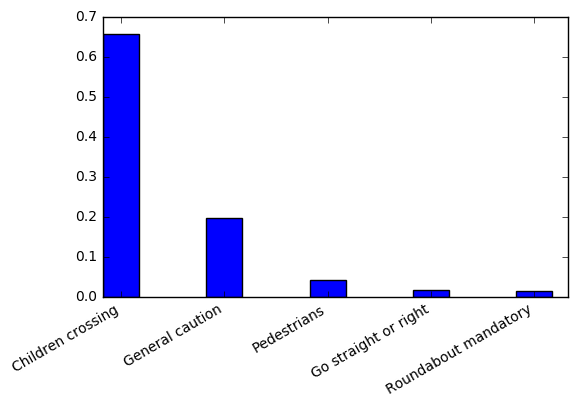

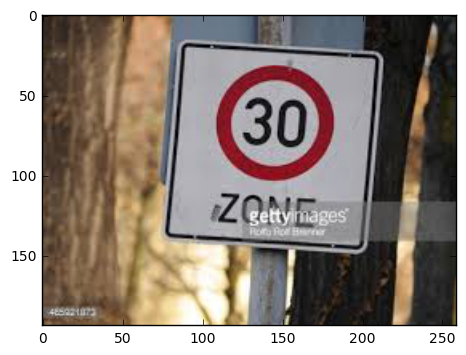

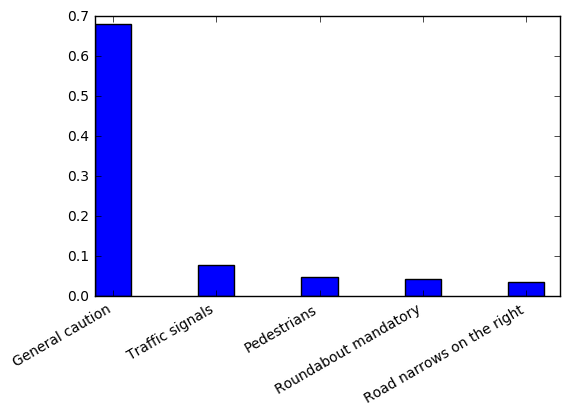

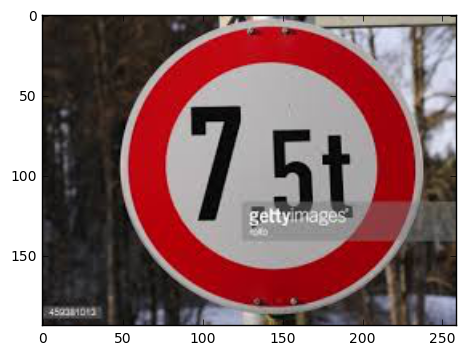

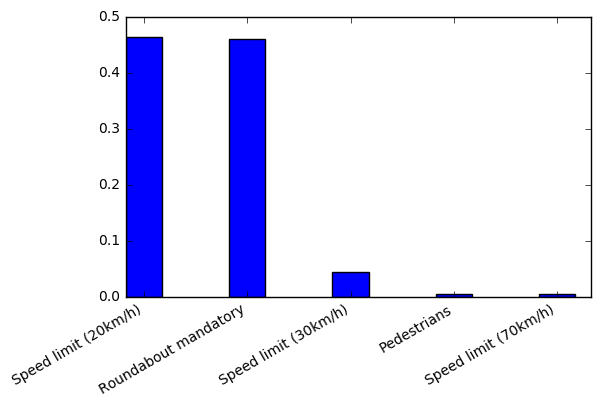

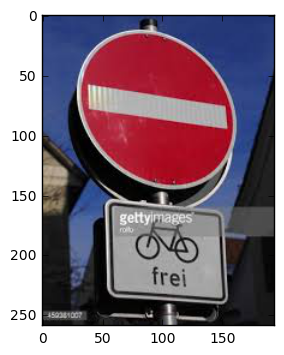

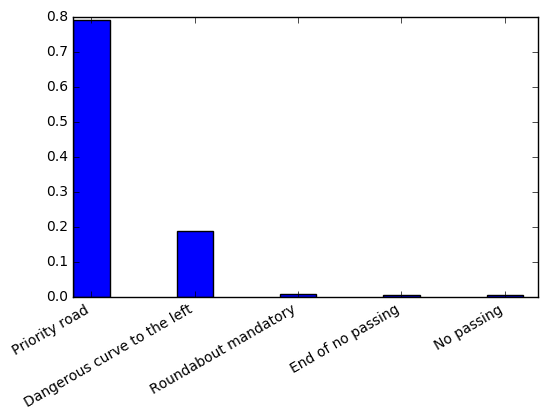

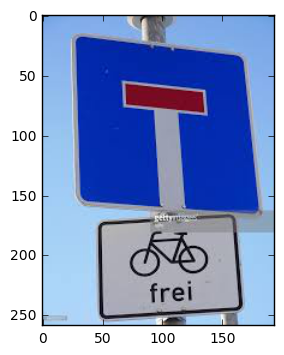

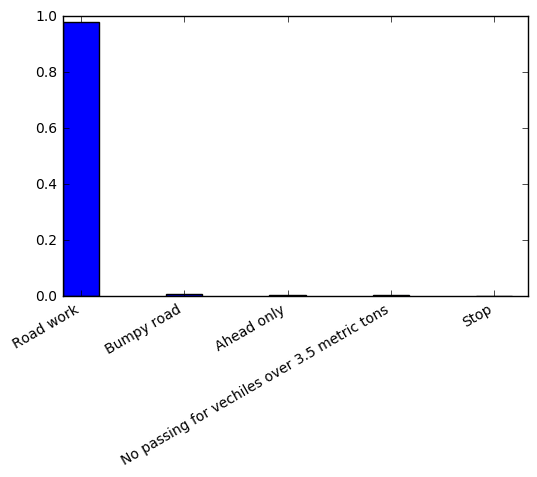

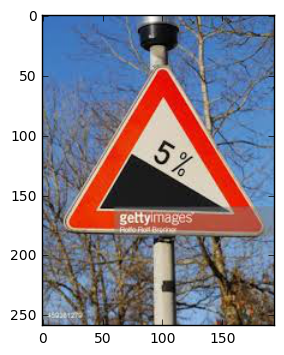

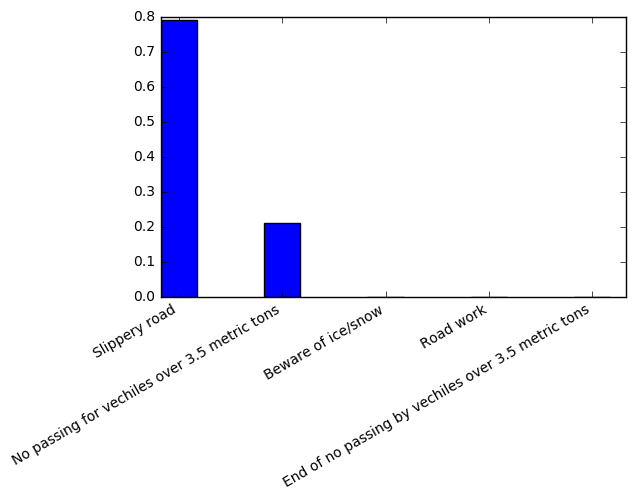

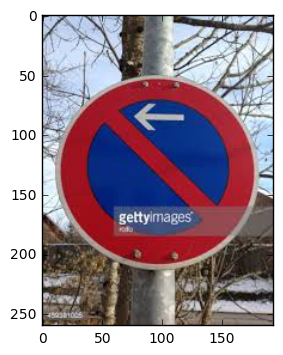

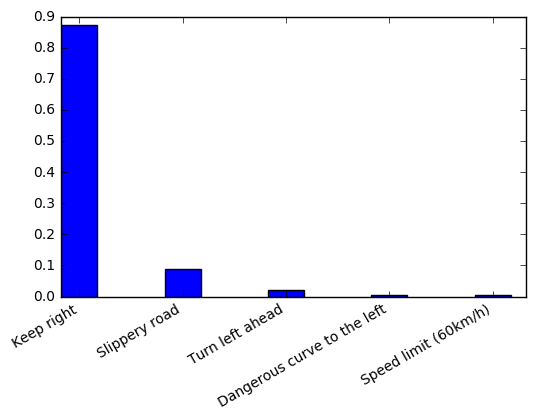

In [15]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

# Create an operation that initializes all variables
init = tf.initialize_all_variables()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

with tf.Session() as session:
    session.run(init)
    
    # Restore variables from disk.
    saver.restore(session, "./model.ckpt")
    print("Model restored.")
       
    [prediction_probs, prediction_classes] = session.run(top_k, feed_dict={features: test_images, 
                                                                           labels: test_labels, # dummy 
                                                                           keep_prob: 1.0})
   
    for rgb, prob, klass in zip(test_rgb, prediction_probs, prediction_classes):

        plt.imshow(rgb)
        plt.show()       
        
        fig = plt.figure()
        width = .35
        ind = np.arange(len(prob))
        plt.bar(ind, prob, width=width)
        plt.xticks(ind + width / 2, [signnames[c] for c in klass])

        fig.autofmt_xdate()
        plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

The only 2 it got in the top 5 were (1) general caution (number 5) and (7) no left turn = keep right.  

What was really interesting was seeing the uncertainties.
General caution, 30 zone, no entry and 5 degree slope are all extremely confident, but wrong.  7.5 ton, T junction and no left turn all think it's one of 2 classes with the 3rd place probability down to less than 0.1.

Overall I think this is a rather poor classifier of real world data and I'll have to work hard to get it to perform well on 'images in the wild'.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

Just put the images in the "examples" directory.  The code will pick them up from there, resize, convert to grey and normalise.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.